In [1]:
import os
import random
import cv2
from cv2 import resize
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from tensorflow.keras.preprocessing import image
from PIL import Image
from keras.layers import *
from keras.models import *
from keras.callbacks import EarlyStopping
from keras.utils import load_img
from sklearn.preprocessing import StandardScaler

In [2]:
path = '/Users/Dataset/Age and Gender/UTKFace'

In [3]:
age = []
gender = []
image =[]
images_path = []

In [4]:
for imagename in tqdm(os.listdir(path)):
    image_path = os.path.join(path,imagename)
    entry = imagename.split('_')
    age.append(int(entry[0]))
    gender.append(int(entry[1]))
    image.append(imagename)
    images_path.append(image_path)

100%|█████████████████████████████████| 23708/23708 [00:00<00:00, 675942.38it/s]


In [5]:
df = pd.DataFrame({'Image path':images_path, 'Image':image,'Gender':gender,'Age':age})

In [6]:
Gender_dct = {1:'Female',
          0: 'Male'}
Gender_dct

{1: 'Female', 0: 'Male'}

In [7]:
df.head(10)

,Image path,Image,Gender,Age
0,/Users/Dataset/Age and Gender/UTKFace/9_1_2_20...,9_1_2_20161219204347420.jpg.chip.jpg,1,9
1,/Users/Dataset/Age and Gender/UTKFace/36_0_1_2...,36_0_1_20170117163203851.jpg.chip.jpg,0,36
2,/Users/Dataset/Age and Gender/UTKFace/86_1_0_2...,86_1_0_20170120225751953.jpg.chip.jpg,1,86
3,/Users/Dataset/Age and Gender/UTKFace/26_1_0_2...,26_1_0_20170116171048641.jpg.chip.jpg,1,26
4,/Users/Dataset/Age and Gender/UTKFace/1_1_2_20...,1_1_2_20161219154612988.jpg.chip.jpg,1,1
5,/Users/Dataset/Age and Gender/UTKFace/52_0_1_2...,52_0_1_20170117161018159.jpg.chip.jpg,0,52
6,/Users/Dataset/Age and Gender/UTKFace/25_1_0_2...,25_1_0_20170117134403373.jpg.chip.jpg,1,25
7,/Users/Dataset/Age and Gender/UTKFace/16_0_0_2...,16_0_0_20170104003740977.jpg.chip.jpg,0,16
8,/Users/Dataset/Age and Gender/UTKFace/27_0_3_2...,27_0_3_20170119210058457.jpg.chip.jpg,0,27
9,/Users/Dataset/Age and Gender/UTKFace/36_0_3_2...,36_0_3_20170119180245724.jpg.chip.jpg,0,36


In [8]:
print('Length of Image path: ',len(df['Image path']))
print('Length of Image:      ',len(df['Image']))
print('Length of Gender:     ',len(df['Gender']))      
print('Length of Age:        ',len(df['Age']))

Length of Image path:  23708
Length of Image:       23708
Length of Gender:      23708
Length of Age:         23708


/var/folders/c3/mcz1hw4s6qnbldhn0ss67r6r0000gn/T/ipykernel_28700/2274348601.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Age']);


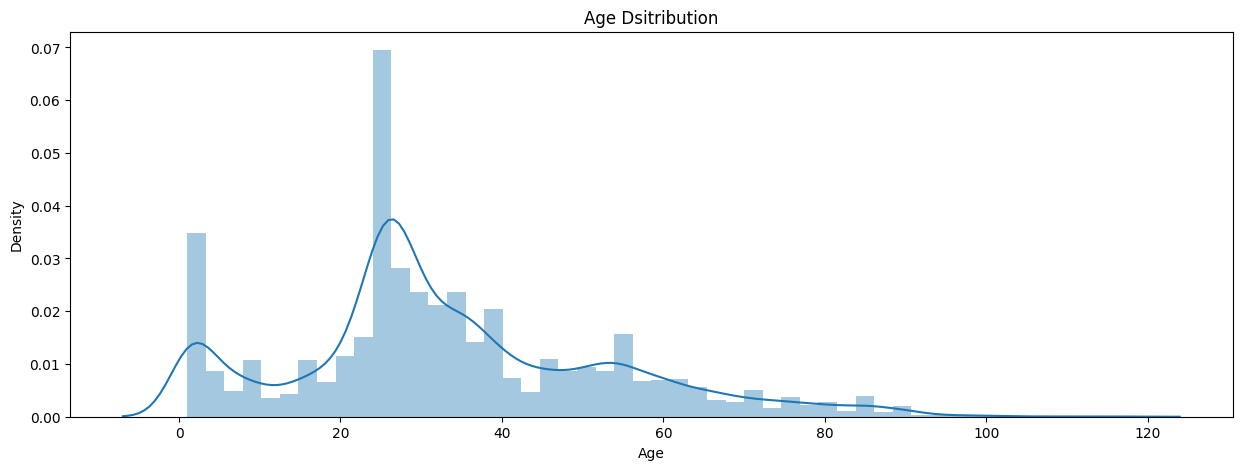

In [9]:
plt.figure(figsize=(15,5))
sns.distplot(df['Age']);
plt.title('Age Dsitribution');

In [10]:
train_data = df.sample(frac=1, random_state=0).iloc[:18968]
test_data = df.sample(frac=1, random_state=0).iloc[18968:]

## Feature Extraction

In [11]:
def extract_feature(images):
    feature=[]
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = img.resize((100,100))
        img = np.array(img)
        feature.append(img)
    feature = np.array(feature)
    feature = feature.reshape(len(feature),100,100,1)
    return feature
        

In [12]:
x = extract_feature(df['Image path'])


  0%|                                                 | 0/23708 [00:00<?, ?it/s]/Users/vilaskhadka/miniconda3/lib/python3.10/site-packages/keras/utils/image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(
100%|███████████████████████████████████| 23708/23708 [00:19<00:00, 1187.85it/s]


In [13]:
x.shape

(23708, 100, 100, 1)

In [14]:
x=x/255

In [15]:
y_gender = np.array(df['Gender'])
encoder = StandardScaler()
y = encoder.fit_transform(df[['Age']])
y_age = np.array(y)


## Build Model


In [16]:
input_shape=(100,100,1)


In [17]:
inputs = Input((input_shape))
conv_1 = Conv2D(filters=32, kernel_size=(3,3), activation='relu', )(inputs)
drop_1 = Dropout(0.2)(conv_1)
maxp_1 = MaxPooling2D(pool_size=(2,2))(drop_1)

conv_2 = Conv2D(filters=64, kernel_size=(3,3), activation='relu', )(maxp_1)
drop_2 = Dropout(0.2)(conv_2)
maxp_2 = MaxPooling2D(pool_size=(2,2))(drop_2)

conv_3 = Conv2D(filters=128, kernel_size=(3,3), activation='relu', )(maxp_2)
drop_3 = Dropout(0.2)(conv_3)
maxp_3 = MaxPooling2D(pool_size=(2,2))(drop_3)

conv_4 = Conv2D(filters=256, kernel_size=(3,3), activation='relu', )(maxp_3)
drop_4 = Dropout(0.2)(conv_4)
maxp_4 = MaxPooling2D(pool_size=(2,2))(drop_4)

flatten = Flatten()(maxp_4)

Metal device set to: Apple M2


In [18]:
dens_1 = Dense(units=256, activation='relu')(flatten)
dens_2 = Dense(units=256, activation='relu')(flatten)

output_1 = Dense(units=1, activation='sigmoid', name='Gender_classification')(dens_1)  # For gender classification
output_2 = Dense(units=1, activation='relu', name='Age')(dens_2)


## Compile Model


In [19]:
model=Model(inputs=[inputs], outputs=[output_1,output_2])
model.compile(loss=['binary_crossentropy','mae'], optimizer='adam')


In [20]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 98, 98, 32)   320         ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 98, 98, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 49, 49, 32)   0           ['dropout[0][0]']            

In [21]:
ess = EarlyStopping(monitor='loss', patience=5)


In [ ]:
history = model.fit(x=x, y=[y_gender,y_age], epochs=100, callbacks=[ess],validation_split=0.2)


Epoch 1/100


2023-07-16 00:39:28.821215: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


593/593 [==============================] - 49s 76ms/step - loss: 1.2597 - Gender_classification_loss: 0.4918 - Age_loss: 0.7679 - val_loss: 1.2021 - val_Gender_classification_loss: 0.4138 - val_Age_loss: 0.7882
Epoch 2/100
593/593 [==============================] - 46s 78ms/step - loss: 1.0993 - Gender_classification_loss: 0.3315 - Age_loss: 0.7678 - val_loss: 1.1171 - val_Gender_classification_loss: 0.3289 - val_Age_loss: 0.7882
Epoch 3/100
593/593 [==============================] - 46s 78ms/step - loss: 1.0639 - Gender_classification_loss: 0.2961 - Age_loss: 0.7678 - val_loss: 1.1051 - val_Gender_classification_loss: 0.3169 - val_Age_loss: 0.7882
Epoch 4/100
593/593 [==============================] - 47s 78ms/step - loss: 1.0343 - Gender_classification_loss: 0.2665 - Age_loss: 0.7678 - val_loss: 1.0994 - val_Gender_classification_loss: 0.3112 - val_Age_loss: 0.7882
Epoch 5/100
 18/593 [..............................] - ETA: 40s - loss: 1.0240 - Gender_classification_loss: 0.2486 - Ag

In [ ]:
plt.plot(history.history['Gender_classification_accuracy'],label='Model accuracy')
plt.plot(history.history['val_Gender_classification_accuracy'], label='Validation accuracy')
plt.legend()
plt.show();

In [ ]:
plt.plot(history.history['loss'],label='Model loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show();


In [ ]:
def extract_feature(images):
    feature=[]
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = img.resize((100,100))
        img = np.array(img)
        feature.append(img)
    feature = np.array(feature)
    feature = feature.reshape(len(feature),100,100,1)
    return feature

In [ ]:
img = '/Users/Dataset/Age and Gender/test.png'
img = load_img(img, grayscale=True)
image = img.resize((100,100))
image = np.array(image)
image = image.reshape(1,100,100,1)


In [ ]:
image_pred = model.predict(image)
predict_gender = Gender_dct[round(image_pred[0][0][0])]
pred_age = round(image_pred[1][0][0])
print("\n predicted Gender: ",predict_gender, '\n Predicted Age:    ',pred_age)
plt.imshow(img);

In [ ]:
len(image_pred)

In [ ]:
image_pred[0]

In [ ]:
image_pred[1]